<a href="https://colab.research.google.com/github/Isabellitankian/FIAP---2023/blob/main/Segmenta%C3%A7%C3%A3o_de_Imagens_com_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Imagens com Detectron 2

- Para implementar a Segmentação Panóptica (*panoptic segmentation*), usaremos a a biblioteca Detectron2, desenvolvida em PyTorch pelo [FAIR](https://ai.facebook.com/) (*Facebook AI Research*). Também usaremos o DETR (DEtection TRansformer) para a detecção de objetos.

- Mais sobre o Detectron2: https://ai.facebook.com/tools/detectron2/ ([repositório no Github](https://github.com/facebookresearch/Detectron2))
- Mais sobre o DETR no paper: https://arxiv.org/pdf/2005.12872.pdf 

# Importação e instalação das bibliotecas

In [ ]:
import io
import cv2
import math
import matplotlib.pyplot as plt
import requests
from PIL import Image

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
from copy import deepcopy
from google.colab.patches import cv2_imshow
torch.set_grad_enabled(False);

In [ ]:
#!pip install torch==1.9.0 torchvision==0.10.0
#import torch; print(torch.__version__)  #mostra versão
#!python -m pip install pip==21.3
#!pip --version #mostra versão

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git

In [ ]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git
!pip install ./detectron2
!pip install --upgrade pyyaml

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/fotos fotos/

cp: cannot stat '/content/gdrive/MyDrive/Cursos - recursos/Segmentação Imagens Python AZ/fotos': No such file or directory


# Normalização

- Método padrão usado pelo Pytorch para normalização [mean-std](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html)
- mean = [0.485, 0.456, 0.406] 
- std = [0.229, 0.224, 0.225]

In [ ]:
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
transform

Compose(
    Resize(size=800, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Carregamento da rede neural

In [ ]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, 
                                      return_postprocessor = True, num_classes=250)

In [ ]:
model

In [ ]:
postprocessor

PostProcessPanoptic()

# Preparação da imagem

In [ ]:
imagem = Image.open('/content/cacatua.jpg')
print(imagem)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=274x184 at 0x7F6DBB0B7B10>


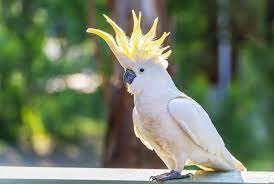

In [ ]:
imagem

In [ ]:
imagem.getpixel((0,0))

(96, 122, 59)

In [ ]:
img = transform(imagem).unsqueeze(0)

In [ ]:
img

tensor([[[[-0.4739, -0.4739, -0.4911,  ..., -1.5357, -1.5357, -1.5357],
          [-0.4739, -0.4739, -0.4911,  ..., -1.5357, -1.5357, -1.5357],
          [-0.4739, -0.4739, -0.4911,  ..., -1.5357, -1.5357, -1.5357],
          ...,
          [-0.0801, -0.0801, -0.0801,  ...,  0.2624,  0.2624,  0.2624],
          [-0.0972, -0.0972, -0.0972,  ...,  0.1939,  0.1939,  0.1939],
          [-0.0972, -0.0972, -0.0972,  ...,  0.1939,  0.1939,  0.1939]],

         [[ 0.1001,  0.1001,  0.0826,  ..., -1.4055, -1.4055, -1.4055],
          [ 0.1001,  0.1001,  0.0826,  ..., -1.4055, -1.4055, -1.4055],
          [ 0.1001,  0.1001,  0.0826,  ..., -1.4055, -1.4055, -1.4055],
          ...,
          [ 0.7129,  0.7129,  0.7129,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.7129,  0.7129,  0.7129,  ...,  0.3978,  0.3978,  0.3978],
          [ 0.7129,  0.7129,  0.7129,  ...,  0.3978,  0.3978,  0.3978]],

         [[-0.7761, -0.7761, -0.7761,  ..., -1.2293, -1.2293, -1.2293],
          [-0.7761, -0.7761, -

# Segmentação

In [ ]:
out = model(img)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
out

{'pred_logits': tensor([[[-17.0973,   3.3458,  -3.7688,  ..., -17.1934, -16.2860,  11.9397],
          [-15.3499,  -3.6391,  -8.0665,  ..., -15.8615, -15.0949,  11.9647],
          [-16.3217,   0.9116,  -3.5750,  ..., -16.4136, -16.1288,  11.2233],
          ...,
          [-19.1396,  -1.5805,  -7.7025,  ..., -19.4483, -18.7285,  13.8914],
          [-16.4729,  -3.5487,  -9.1538,  ..., -17.4301, -16.9536,  12.2449],
          [-17.4637,  -1.6805,  -6.7202,  ..., -18.0726, -17.9144,  13.2577]]]),
 'pred_boxes': tensor([[[0.4786, 0.4461, 0.3293, 0.8916],
          [0.7931, 0.9375, 0.0480, 0.0567],
          [0.5296, 0.4720, 0.7232, 0.9327],
          [0.3332, 0.4513, 0.5976, 0.8995],
          [0.5000, 0.9750, 0.9982, 0.0453],
          [0.5001, 0.9499, 0.9979, 0.0970],
          [0.7402, 0.9282, 0.0974, 0.0629],
          [0.5000, 0.8976, 0.9986, 0.2024],
          [0.5000, 0.4985, 0.9986, 0.9977],
          [0.7160, 0.9211, 0.0817, 0.0733],
          [0.3837, 0.8607, 0.7723, 0.1757],
 

In [ ]:
out['pred_logits'].size()

In [ ]:
scores = out['pred_logits'].softmax(-1)[...,:-1].max(-1)[0]

In [ ]:
scores

# Retorno das máscaras

In [ ]:
keep = scores > 0.85
print(keep)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])


In [ ]:
math.ceil(keep.sum().item() / 5)

In [ ]:
n_colunas = 5
fig, axs = plt.subplots(ncols=n_colunas, nrows=math.ceil(keep.sum().item() / n_colunas), figsize=(18,10))
for line in axs:
  for a in line:
    a.axis('off')
for i, mask in enumerate(out['pred_masks'][keep]):
  ax = axs[i // n_colunas, i % n_colunas]
  ax.imshow(mask, cmap='cividis')
  ax.axis('off')

# Unificação dos segmentos

In [ ]:
img.shape, img.shape[-2:], torch.as_tensor(img.shape[-2:]).unsqueeze(0)[0]

In [ ]:
resultado = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

In [ ]:
resultado

In [ ]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

In [ ]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))
seg_panoptica = numpy.array(seg_panoptica, dtype=numpy.uint8).copy()
seg_panoptica_id = rgb2id(seg_panoptica)

In [ ]:
seg_panoptica_id.shape

In [ ]:
import numpy as np

In [ ]:
seg_panoptica_id, np.unique(seg_panoptica_id, return_counts = True)

In [ ]:
seg_panoptica[:,:,:] = 0
for id in range(seg_panoptica_id.max() + 1):
  seg_panoptica[seg_panoptica_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(seg_panoptica)
plt.axis('off')

# Visualização final com Detectron2

In [ ]:
resultado['segments_info']

In [ ]:
# https://en.wikipedia.org/wiki/Object_copying#:~:text=Deep%20copy%20is%20a%20process,is%20copied%20in%20other%20object.
info_segmentos = deepcopy(resultado['segments_info'])

In [ ]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))

In [ ]:
final_w, final_h = seg_panoptica.size
print(final_w, final_h)

In [ ]:
seg_panoptica = numpy.asarray(seg_panoptica, dtype=numpy.uint8)
seg_panoptica = torch.from_numpy(rgb2id(seg_panoptica))

In [ ]:
meta = MetadataCatalog.get('coco_2017_val_panoptic_separated')
for i in range(len(info_segmentos)):
  c = info_segmentos[i]['category_id']
  #print(c)
  info_segmentos[i]['category_id'] = meta.thing_dataset_id_to_contiguous_id[c] if info_segmentos[i]['isthing'] else meta.stuff_dataset_id_to_contiguous_id[c]

In [ ]:
info_segmentos

In [ ]:
cores_classes = meta.stuff_colors
cores_classes

In [ ]:
v = Visualizer(numpy.array(imagem.copy().resize((final_w, final_h)))[:,:,::-1], meta, scale=1.0)
v = v.draw_panoptic_seg_predictions(seg_panoptica, info_segmentos)
resultado_final = v.get_image()
cv2_imshow(resultado_final)